# Sensitivity Guided Analysis of Input & Pruning of Neural Networks in Image Classification

## Motivation

The motivation behind this notebook is to explore the sensitivity of neural networks to input data and to use this information to guide the pruning of the network. 
From the paper from the paper [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929), which the using of attention mechanism allows ViT to be dynamic in how it processes images. It can focus on more relevant parts of the image (e.g., where the object of interest is located) while paying less attention to less relevant areas.


![Example Image](attention.jpg)

The idea of this project is to identify the most sensitive neurons and prune them to reduce the network size while maintaining the accuracy (or even improving it). The sensitivity of the different pixels in the input image is calculated by the variance of output when the certain pixel changes. We then can apply a mask to the input image to remove the less sensitive pixels and reduce the input size, which can be used to make the model less redundant and more efficient, and reduce the computational cost of the model.

Borrow the idea from the paper [Look at the Variance! Efficient Black-box Explanations with Sobol-based Sensitivity Analysis](https://arxiv.org/abs/2111.04138), we will use the sensitivity of the neurons to the input data to guide the pruning of the network. The sensitivity analysis also provide us a way to capture the high-order interations between the different pixels in the image. 

The sensitivity of the neurons is calculated using the gradient of the output with respect to the input. The neurons with the highest sensitivity are pruned to reduce the network size while maintaining the accuracy.

This code is a simple implementation of Sobol index in image classifications. It is a low-discrepancy sequence that is used in Monte Carlo simulations. The code is based on the original paper by Ilya Sobol, "On the Distribution of Points in a Cube and the Approximate Evaluation of Integrals" (1967). 

## Implementation

### Before the experiment

Import the necessary libraries and load the data. I will use the MNIST dataset for this experiment. The MNIST dataset is a collection of 28x28 pixel images of handwritten digits from 0 to 9. The dataset contains 60,000 training images and 10,000 test images. I will use the training images to train the model and the test images to evaluate the model.

![Example Image](MNIST.jpg)

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import numpy as np

In [2]:
# check the GPU device
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Use a simple fully connected neural network to classify the images, which is enough for MNIST dataset.

In [3]:
# Define Hyper-parameters
input_size = 784
hidden_size_1 = 300
hidden_size_2 = 100
num_classes = 10
num_iter = 10
batch_size = 64
learning_rate = 1.2e-3
weight_decay = 1.0 / 50000

Load the data and define the model.

In [4]:
# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='data',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='data',
                                          train=False,
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

The test layers are defined to calculate the sensitivity of the neurons to the input data. In the further experiment, I will also considering the sensitivity mechanism in each activation function, and not just the input layer. That's why there're TestNet_fc3 and TestNet_fc3.

In [5]:
# LeNet-300-100
class LeNet(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, num_classes):
        super(LeNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size_1)
        self.tanh = nn.Tanh()
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.fc3 = nn.Linear(hidden_size_2, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.tanh(out)
        out = self.fc2(out)
        out = self.tanh(out)
        out = self.fc3(out)
        return out

# test net fc2
class TestNet_fc2(nn.Module):
    def __init__(self, hidden_size_1, hidden_size_2, num_classes):
        super(TestNet_fc2, self).__init__()
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.tanh = nn.Tanh()
        self.fc3 = nn.Linear(hidden_size_2, num_classes)

    def forward(self, x):
        out = self.fc2(x.to(device))
        out = self.tanh(out)
        out = self.fc3(out)
        return out

# test net fc3
class TestNet_fc3(nn.Module):
    def __init__(self, hidden_size_2, num_classes):
        super(TestNet_fc3, self).__init__()
        self.fc3 = nn.Linear(hidden_size_2, num_classes)

    def forward(self, x):
        out = self.fc3(x.to(device))
        return out

In [6]:
# Initialize the model
model = LeNet(input_size, hidden_size_1, hidden_size_2, num_classes).to(device)
# model.load_state_dict(torch.load('20201006/weight_decay=1.0e-4/final_state_dict_model.pt'))
prune_iter = 0
masks = list()
accuracies = list()
num_parameters = list()
num_zero_Si_indices = 1

### Sensitivity Analysis

There are many ways to dertermine the sensitivity across the input data. In this experiment, I will use the Sobol index to calculate the sensitivity of the neurons to the input data. Working within a probabilistic framework, it decomposes the variance of the output of the model or system into fractions which can be attributed to inputs or sets of inputs.

In the general cases, for example, given a model with two inputs and one output, one might find that 70% of the output variance is caused by the variance in the first input, 20% by the variance in the second, and 10% due to interactions between the two. In our case, there will be a certain number of inputs (pixels) are more inportant than others, and the interactions between the pixels are also important. The Sobol index can help us to identify the most important pixels and the interactions between them.

There are two ways to calculate the sobol index, the first-order Sobol index and the total-order Sobol index. The first-order Sobol index measures the sensitivity of the output to a single input, while the total-order Sobol index measures the sensitivity of the output to a single input, including the interactions with other inputs. In this experiment, I will use the first-order Sobol index to calculate the sensitivity of the neurons to the input data. The total-order Sobol index experiments are also done and will be shown in the slides.

First-order Sobol index is calculated as follows:

![Example Image](first_order.jpg)

Total-order Sobol index is calculated as follows:

![Example Image](total_order.jpg)

It's also worth to mention that, the Sobol index is a low-discrepancy sequence that is normally calculated by Monte Carlo, which is basiclly generate pertuabations among the different pixels. But my method will be different, all the pertuabations will be generated will be calculated only based on the variance between different batches of input dataset.

![Example Image](compute_sensitivity.jpg)

In [7]:
def compute_sensitivity_indices(inputs, test_model):
    Si = np.zeros((inputs[0].shape[1]))
    rng = np.random.default_rng()
    index = rng.choice(len(inputs)-1, size=16, replace=False)
    mean = 0
    for i in index:
        A = inputs[i]
        mean += np.mean(A, axis=0)
        j = rng.choice(len(inputs)-1, size=1, replace=False)[0]
        while j == i:
            j = rng.choice(len(inputs)-1, size=1, replace=False)[0]
        B = inputs[j]

        for d in range(inputs[0].shape[1]):
            A_ = np.copy(A)
            A_[:, d] = B[:, d]
            outputs_ = test_model(torch.from_numpy(A_).to(device))
            outputs = test_model(torch.from_numpy((A)).to(device))
            # Si[d] += (torch.norm(outputs_) - torch.norm(outputs)).item() ** 2
            # Si[d] += torch.norm(outputs_) - torch.norm(outputs)
            # Si[d] += torch.norm(outputs*(outputs_-outputs))
            Si[d] += (torch.mean(outputs_) - torch.mean(outputs)).item() ** 2

    Si = Si / 16
    mean = mean / 16

    return Si, mean

Here are two functions used for weights pruning and zero value parameters counting.

In [8]:
def prune_weights(model, low_Si_indices, mean):
    bias_adjustment = 0
    with torch.no_grad():
        for i in low_Si_indices:
            bias_adjustment += model.fc2.weight[:, i].detach().numpy() * mean[i]
            model.fc2.weight[:, i].zero_()
            model.fc1.weight[i, :].zero_()
            model.fc1.bias[i].zero_()
        model.fc2.bias.add_(torch.from_numpy(bias_adjustment))

    return model

def count_zero_params(model):
    zeros = 0
    for param in model.parameters():
        if param.requires_grad:
            zeros += torch.sum((param.data==0).int()).item()
    return zeros

### Trainer

Loss function and optimizer are defined.

In [9]:
def compute_loss(model, test_loader, device, criterion, masks=[]):
    with torch.no_grad():
        loss = 0
        total = 0
        for images, labels in test_loader:
            images = images.reshape(-1, 28 * 28).to(device)
            for mask in masks:
                images = torch.index_select(images, 1, torch.from_numpy(mask)).to(device)
            labels = labels.to(device)
            outputs = model(images)
            total += labels.size(0)
            loss += criterion(outputs, labels)

    loss = loss / total
    print(loss.item())

In [10]:
def train_model_SGD(model, train_loader, num_iter, device, criterion, optimizer, masks=[]):
    # Train the model
    i = 0
    while i < num_iter:
        for images, labels in train_loader:
            # Move tensors to the configured device
            images = images.reshape(-1, 28 * 28).to(device)
            for mask in masks:
                mask_tensor = torch.from_numpy(mask).to(device)
                images = torch.index_select(images, 1, mask_tensor)
            labels = labels.to(device)

            """
            SGD
            """
            # Forward pass
            outputs = model(images.to(device))
            loss = criterion(outputs, labels)

            # Backprpagation and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i + 1) % 10000 == 0:
                print('Iteration [{}/{}], Loss: {:.4f}'
                      .format(i + 1, num_iter, loss.item()))

            i += 1

    return model

In [11]:
def Test_model(model, test_loader, device, masks=[]):
    # test the model
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.reshape(-1, 28 * 28).to(device)
            for mask in masks:
                images = torch.index_select(images, 1, torch.from_numpy(mask).to(device))
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

    return 100 * correct / total

### Calculate Sensitivity

Hook the output after each layer and calculate the sensitivity of the neurons to the input data.

For the sensitivity analysis on the input layer, the hook is not that important, since it will only be the 784 pixels of each image. But for the sensitivity analysis on the activation function, the hook is important, since it will be the neurons of the activation function.

In [12]:
# hook to collect inputs
inputs_fc1 = list()
def collect_input_fc1(self, input, output):
    if device != torch.device('cpu'):
        inputs_fc1.append(input[0].cpu().detach().numpy())
    else:
        inputs_fc1.append(input[0].detach().numpy())

model.fc1.register_forward_hook(collect_input_fc1)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)



Training. The sensitivity is calculated during the training process.

In [13]:
print('Training...')
train_model_SGD(model, train_loader, num_iter, device, criterion, optimizer, masks)

# Test the model
# print(format(prune_iter))
pytorch_total_params = sum(p.numel() for p in model.parameters())
print('{} parameters'.format(pytorch_total_params))
accuracy = Test_model(model, test_loader, device, masks)

Training...
266610 parameters
Accuracy of the network on the 10000 test images: 95.43 %


Compute the sensitivity index of the input layer, which is the Si, and mean of the Si.

In [14]:
# Compute Si and mean
test_model = LeNet(input_size, hidden_size_1, hidden_size_2, num_classes).to(device)
test_model.fc1.weight.data = model.fc1.weight.data.to(device)
test_model.fc1.bias.data = model.fc1.bias.data.to(device)
test_model.fc2.weight.data = model.fc2.weight.data.to(device)
test_model.fc2.bias.data = model.fc2.bias.data.to(device)
test_model.fc3.weight.data = model.fc3.weight.data.to(device)
test_model.fc3.bias.data = model.fc3.bias.data.to(device)
Si_fc1, mean_fc1 = compute_sensitivity_indices(inputs_fc1, test_model)
# print('Sensitivity index of the input image:', Si_fc1)

Si = {'fc1': Si_fc1}
mean = {'fc1': mean_fc1}

Plor the sensitivity index of the input image. Look, it varies a lot!

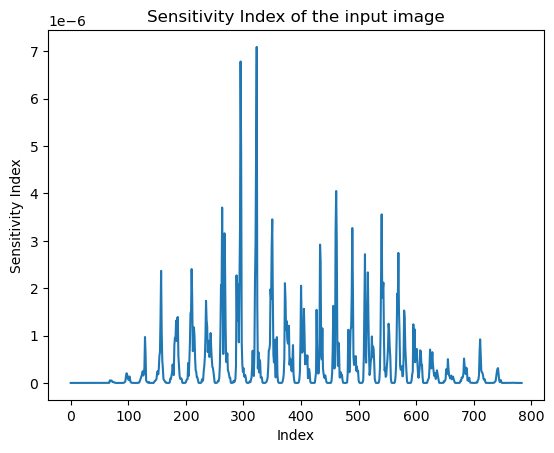

In [15]:
# Plot Si according to index
import matplotlib.pyplot as plt
plt.plot(Si_fc1)
plt.xlabel('Index')
plt.ylabel('Sensitivity Index')
plt.title('Sensitivity Index of the input image')
plt.show()

We can also calculate the sensitivity index based on different digits, and compare the results. It's also interesting to see the difference. Obviously, the sensitivity index of the digit 9 is going to be different from the digit 0.

However, it won't be helpful for our training process, since the input images are not the same. We can't just use the sensitivity index of the digit 0 to prune the input images of the digit 9. So our index will always be based on all the digits.

In [16]:
# Initialize containers for inputs and labels
inputs_fc1 = []
labels_fc1 = []

# Define a modified testing phase or data collection process
def collect_data_for_sensitivity_analysis(model, data_loader, device):
    model.eval()  # Ensure the model is in evaluation mode
    with torch.no_grad():
        for images, labels in data_loader:
            images_flat = images.reshape(-1, 28 * 28).to(device)
            labels = labels.to(device)

            # Assuming you're collecting inputs right before they're passed to fc1
            outputs = model(images_flat)

            # Store inputs and labels
            # Here you may need to detach and move data to CPU if storing on CPU
            inputs_fc1.extend(images_flat.cpu().numpy())
            labels_fc1.extend(labels.cpu().numpy())

# Collect data
collect_data_for_sensitivity_analysis(model, test_loader, device)


Heat map for the MNIST dataset. It's interesting to see the sensitivity index of the input images. Most important indices are based on the center of the image, which is the most important part of the image.

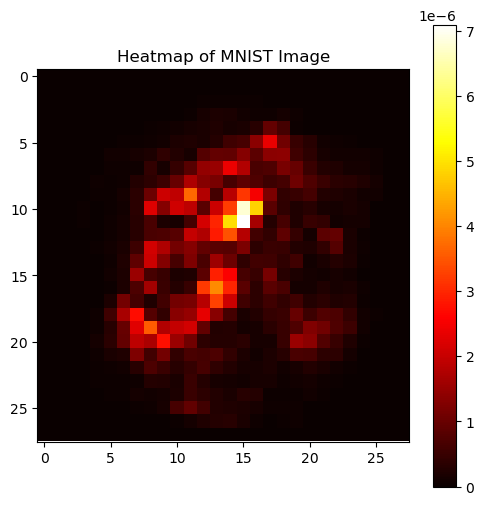

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming Si_fc1 is your array and needs to be reshaped for an MNIST image

Si_fc1_reshaped = Si_fc1.reshape(28, 28)  # Correct reshaping for MNIST

# Plotting the heatmap directly since it's already a grayscale image
plt.figure(figsize=(6, 6))
plt.imshow(Si_fc1_reshaped, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title("Heatmap of MNIST Image")
plt.show()


Also draw the histogram of the sensitivity index. It's interesting to see the distribution of the sensitivity index. Most of the sensitivity index are close to 0, which means they are not that important. But there are also some of them are very important, which means they are very sensitive to the input data. We should keep them.

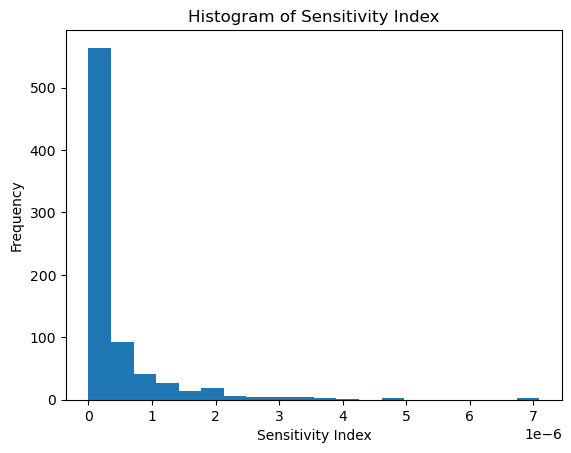

In [18]:
# Plot the histogram of Si
plt.hist(Si_fc1, bins=20)
plt.xlabel('Sensitivity Index')
plt.ylabel('Frequency')
plt.title('Histogram of Sensitivity Index')
plt.show()

### Generate the mask based on the sensitivity index

In [19]:
# Calculate ranking of indices
ranking_fc1 = np.argsort(Si_fc1)

# Determine the number of indices to prune (50%)
prune_ratio = 0.5
num_prune_fc1 = int(prune_ratio * len(ranking_fc1))

# Prune the smallest prune_ratio
zero_Si_indices = ranking_fc1[:num_prune_fc1]

# Calculate the remaining non-zero indices
non_zero_Si_indices = ranking_fc1[num_prune_fc1:]


Draw the mask of then MNIST image, which will only input the most important pixels to the model (around the center of the image). The pruning ratio is set to 0.5, which means we will only keep the top 50% of the most important pixels.

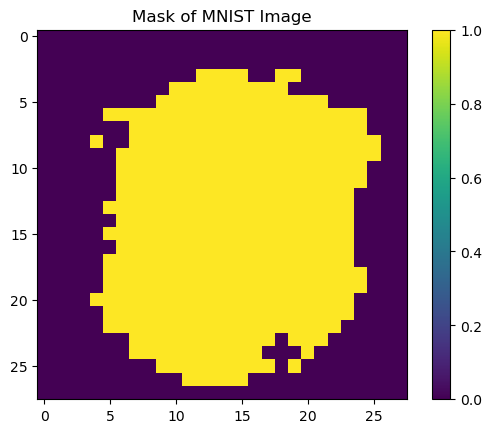

In [20]:
# Plot the remaining non-zero Si indices, and make it back to the original shape
Si_fc1_reshaped = np.zeros(28*28)
Si_fc1_reshaped[non_zero_Si_indices] = 1
Si_fc1_reshaped = Si_fc1_reshaped.reshape(28, 28)
plt.imshow(Si_fc1_reshaped)
plt.colorbar()
plt.title("Mask of MNIST Image")
plt.show()

Do the pruning:

In [21]:
print('Pruning following number of neurons in the input layer')
print('Input layer: {}'.format(num_prune_fc1))

# Print the number of remaining neurons after pruning
remaining_fc1 = len(non_zero_Si_indices)
print('Remaining neurons after pruning...')
print('Input layer: {}'.format(remaining_fc1))

Pruning following number of neurons in the input layer
Input layer: 392
Remaining neurons after pruning...
Input layer: 392


Do the bias adjustment for the first layer:

In [22]:
# Compute bias adjustments for only the first layer
layer = 'fc1'  
size = hidden_size_1  
bias_adjustment = dict()
with torch.no_grad():
    bias_adjustment[layer] = np.zeros(size)
    for i in zero_Si_indices:
        for parameter in model.named_parameters():
            if parameter[0] == layer + '.weight':
                # Adjust bias for the specified layer
                bias_adjustment[layer] += parameter[1].data[:, i].cpu().numpy() * mean[layer][i]

### Test the masked input

Initialize a new model and test the accuracy of the pruned model.

In [23]:
# Initialize a new model without changing the sizes based on pruning, except for adjustments in fc1
input_size = 784
input_size = input_size - len(zero_Si_indices)
new_model = LeNet(input_size, hidden_size_1, hidden_size_2, num_classes).to(device)

# Adjust weights for fc1 based on non-zero Si indices
# Ensure that zero_Si_indices and non_zero_Si_indices are for fc1 specifically if using a dictionary as in your original setup.
x = model.fc1.weight.data.to(device)

# Assuming non_zero_Si_indices is correctly calculated for fc1 and is a numpy array
# If non_zero_Si_indices is not a numpy array, adjust accordingly
x = torch.index_select(x, 1, torch.from_numpy(non_zero_Si_indices).to(device))
new_model.fc1.weight.data = x

# Adjust bias for fc1 - No need for index selection for bias as it corresponds to output neurons
new_model.fc1.bias.data = model.fc1.bias.data.to(device)

# Copy over fc2 and fc3 weights and biases without adjustment since we're only focusing on fc1
new_model.fc2.weight.data = model.fc2.weight.data.to(device)
new_model.fc2.bias.data = model.fc2.bias.data.to(device)
new_model.fc3.weight.data = model.fc3.weight.data.to(device)
new_model.fc3.bias.data = model.fc3.bias.data.to(device)


In [24]:
masks.append(non_zero_Si_indices)
accuracies.append(accuracy)
num_parameters.append(pytorch_total_params)
model = new_model

In [27]:
train_model_SGD(model, train_loader, 1, device, criterion, optimizer, masks)

LeNet(
  (fc1): Linear(in_features=392, out_features=300, bias=True)
  (tanh): Tanh()
  (fc2): Linear(in_features=300, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)

In [28]:
# Test the model
pytorch_total_params = sum(p.numel() for p in model.parameters())
print('{} parameters'.format(pytorch_total_params))
accuracy = Test_model(model, test_loader, device, masks)

149010 parameters
Accuracy of the network on the 10000 test images: 94.71 %


The accuracy maintains (at least!). Actually, the pruning can be done several more times, and also based on other layers I mentioned before. This method can achieves a very high pruning ratio (around 5%, which means only 5% parameters are left), while maintaining the accuracy. 